In [53]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

plt.rcParams['font.family'] = 'DejaVu Sans'
plik = '../data/01_raw/top 500.csv'

try:
     data = pd.read_csv(plik)
     print(f"Plik '{plik}' został poprawnie wczytany.")
except Exception as e:
     print(f"Błąd podczas wczytywania pliku: {e}")
     data = pd.DataFrame()

Plik '../data/01_raw/top 500.csv' został poprawnie wczytany.


In [54]:

# Podstawowe informacje o danych
print("Rozmiar danych:", data.shape)
print("\nTypy kolumn:\n", data.dtypes)
print("\nBrakujące wartości:\n", data.isnull().sum())



Rozmiar danych: (498, 47)

Typy kolumn:
 appid                         int64
name                         object
release_date                 object
required_age                  int64
price                       float64
dlc_count                     int64
detailed_description         object
about_the_game               object
short_description            object
reviews                      object
header_image                 object
website                      object
support_url                  object
support_email                object
windows                        bool
mac                            bool
linux                          bool
metacritic_score              int64
metacritic_url               object
achievements                  int64
recommendations               int64
notes                        object
supported_languages          object
full_audio_languages         object
packages                     object
developers                   object
publishers             

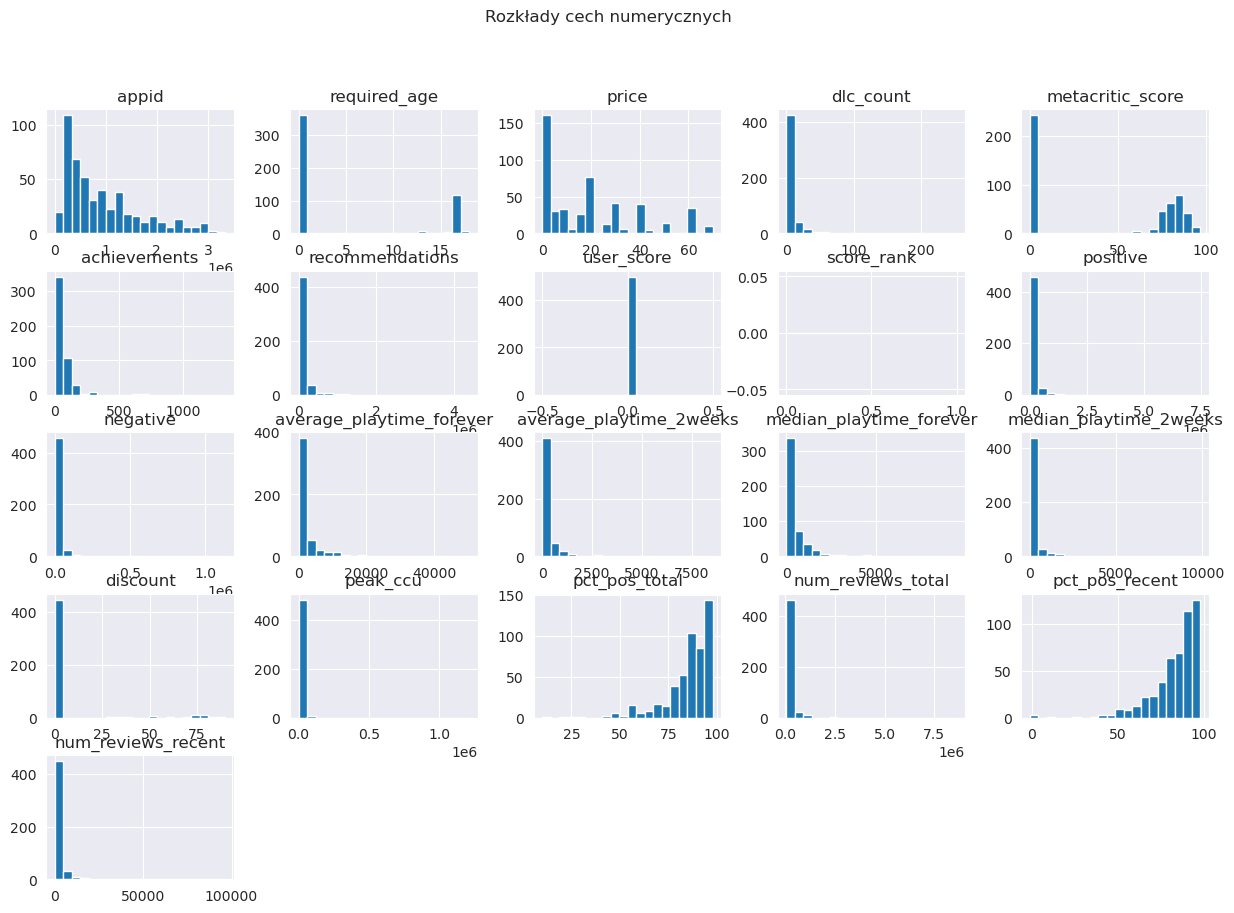

In [55]:

# Rozkłady cech numerycznych
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Rozkłady cech numerycznych")
plt.show()

In [56]:

# Rozkłady cech kategorycznych - skip do zastanowienia


In [57]:

# Wskazanie targetu
target = 'linux'  #todo - do zmiany i wyboru
if target not in data.columns:
    raise ValueError(f"Kolumna target '{target}' nie istnieje w danych!")

print(f"Zmienna docelowa: {target}")
print(data[target].value_counts())

Zmienna docelowa: linux
linux
False    376
True     122
Name: count, dtype: int64


In [58]:
# 1. Uzupełnianie brakujących wartości
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if data[col].dtype in ['float64', 'int64']:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

# Definicja cech kategorycznych
cat_cols = data.select_dtypes(include=['object']).columns
# 2. Enkodowanie zmiennych kategorycznych
if len(cat_cols) > 0:
    data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
print("Rozmiar danych po czyszczeniu:", data.shape)

# Usunięcie wartości odstających
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
z_scores = np.abs(zscore(data[num_cols]))
data_outlier_removed = data[(z_scores < 3).all(axis=1)]
print(f"Rozmiar danych po usunięciu outlierów: {data_outlier_removed.shape}")

# Jeśli po usunięciu outlierów jest mniej niż 10 rekordów, pomiń ten krok
if data_outlier_removed.shape[0] < 10:
    print("Za mało danych po usunięciu outlierów, pomijam ten krok.")
else:
    data = data_outlier_removed
    print("Usunięto outliery.")
print(f"Ostateczny rozmiar danych: {data.shape}")

Rozmiar danych po czyszczeniu: (498, 7381)
Rozmiar danych po usunięciu outlierów: (0, 7381)
Za mało danych po usunięciu outlierów, pomijam ten krok.
Ostateczny rozmiar danych: (498, 7381)


C:\ProgramData\miniconda3\envs\asi-ml\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [59]:
# Ewaluacja modelu
if data.shape[0] < 10:
    print("Za mało danych do ewaluacji modelu. Przerwij analizę lub zmień kryteria czyszczenia.")
else:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score, accuracy_score

    X = data.drop(columns=[target])
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"F1-score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Wybrana metryka: F1-score, ponieważ najlepiej oddaje skuteczność klasyfikatora przy niezbalansowanych klasach i uwzględnia zarówno precyzję, jak i recall.")


F1-score: 0.31
Accuracy: 0.82
Wybrana metryka: F1-score, ponieważ najlepiej oddaje skuteczność klasyfikatora przy niezbalansowanych klasach i uwzględnia zarówno precyzję, jak i recall.
